In [1]:
import maxLFQ.iq as iq
import time
import pandas as pd
import numpy as np

Imported maxLFQpy python package.


In [2]:
sample_id = "R.FileName"
secondary_id = np.array(["EG.Library", "FG.Id", "FG.Charge", "F.FrgIon", "F.Charge", "F.FrgLossType"])

In [3]:
start_time = time.time()
raw = iq.read(r"C:\Users\thank\Documents\MaxLFQ\DIA-report-long-format.txt",
              secondary_id=secondary_id,
              sample_id=sample_id)
raw = raw[(raw['F.ExcludedFromQuantification'] == False) &
          (raw['PG.Qvalue'].notna()) &
          (raw['PG.Qvalue'] < 0.01) &
          (raw["EG.Qvalue"].notna()) &
          (raw['EG.Qvalue'] < 0.01)]
print("read raw data: {0} [sec]".format(time.time() - start_time))

read raw data: 7.908674001693726 [sec]


Concatenating secondary ids...
Removing low intensities...
Barplotting raw data ...
Median normalization ...
preprocess: 35.38812589645386 [sec]


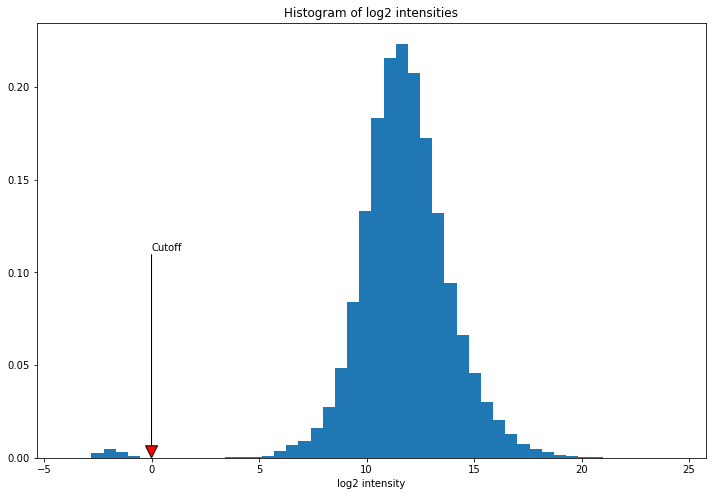

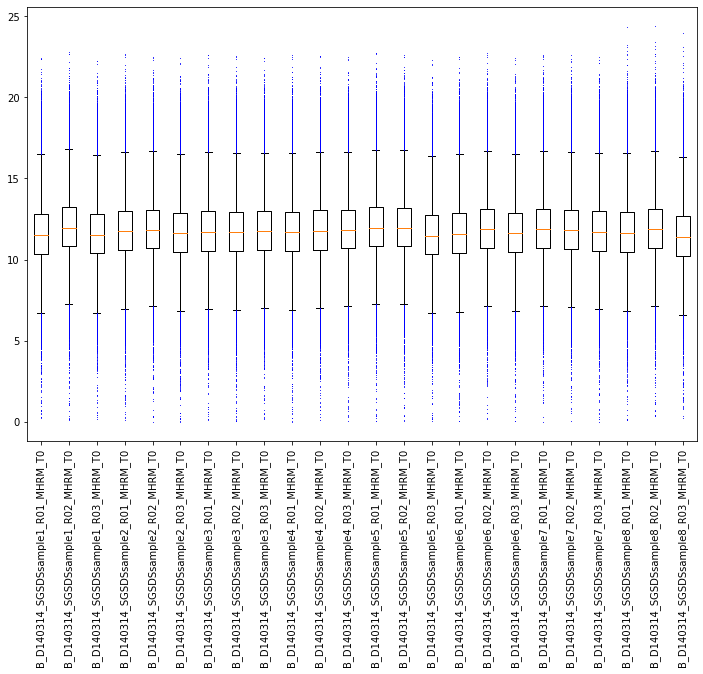

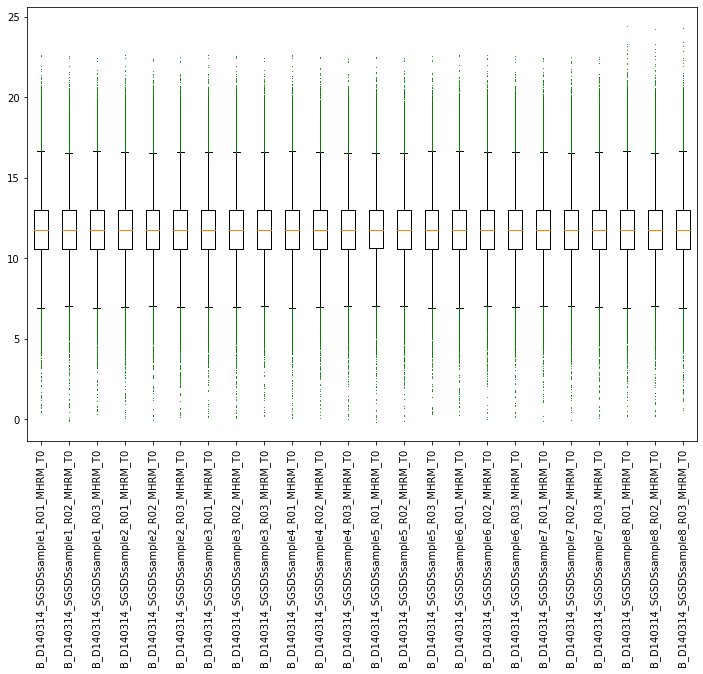

In [4]:
start_time = time.time()
norm_data = iq.preprocess(raw,
                          sample_id=sample_id,
                          secondary_id=secondary_id)
print("preprocess: {0} [sec]".format(time.time() - start_time))

In [14]:
start_time = time.time()
protein_list = iq.create_protein_list(norm_data)
print("create_protein_list: {0} [sec]".format(time.time() - start_time))

Create protein list..
#proteins = 3554, #samples = 24
[####################] 100% Complete!!
create_protein_list: 1018.1390085220337 [sec]


In [ ]:
start_time = time.time()
result = iq.create_protein_table(protein_list, method="maxLFQ")
print("create_protein_table: {0} [sec]".format(time.time() - start_time))

In [31]:
import importlib
importlib.reload(iq)

<module 'maxLFQ.iq' from 'C:\\Users\\thank\\PycharmProjects\\pythonProject\\maxLFQ\\iq.py'>

In [30]:
def preprocess(quant_table,
               primary_id="PG.ProteinGroups",
               secondary_id=np.array(["EG.ModifiedSequence", "FG.Charge", "F.FrgIon", "F.Charge"]),
               sample_id="R.Condition",
               intensity_col="F.PeakArea",
               median_normalization=True,
               log2_intensity_cutoff=0,
               pdf_out="qc-plots.pdf",
               pdf_width=12,
               pdf_height=8,
               intensity_col_sep = None,
               intensity_col_id = None,
               na_string = "0"):
    if isinstance(quant_table, pd.DataFrame):
        
        print("Concatenating secondary ids...")
        second_id = quant_table[secondary_id[0]]
        if quant_table.shape[1] > 1:
            for col in secondary_id[1:]:
                second_id += quant_table[col].astype(str)
                
        if intensity_col_sep is None:
            if not is_numeric_dtype(quant_table[intensity_col]):
                raise TypeError("Intensity column must be numeric when ")

            df = pd.DataFrame({'protein_list': quant_table[primary_id],
                               'sample_list': quant_table[sample_id],
                               'quant': np.log2(quant_table[intensity_col]),
                               'id': second_id})
            #df.dropna(axis=0)
        else:
            v = raw[intensity_col].astype(str).str.split(intensity_col_sep, n=1, expand=True)
            if intensity_col_id is not None:
                v_ids = raw[intensity_col_id].astype(str).str.split(intensity_col_sep, n=1, expand=True)
                
                
        # intensity cut off    
        figs = []
        if log2_intensity_cutoff is not None:
            print('Removing low intensities...')
            if pdf_out is not None:
                # histogram
                fig1 = plt.figure(figsize=(pdf_width, pdf_height))
                n, bins, patch = plt.hist(df['quant'], bins=50, density=True) 
                plt.xlabel('Density')
                plt.xlabel('log2 intensity')
                plt.title('Histogram of log2 intensities')
                plt.annotate('Cutoff',
                             xy =(log2_intensity_cutoff, 0),
                             xytext =(log2_intensity_cutoff, max(n)/2), 
                             arrowprops = dict(width = 0.001,
                                               facecolor ='red',
                                               shrink = 0.0),)
                figs.append(fig1)
            df = df[df["quant"] > log2_intensity_cutoff]
        samples = df['sample_list'].unique()

        if pdf_out is not None:
            dl = []
            m = []
            for index, sample in enumerate(samples):
                dl.append(df.loc[df['sample_list'] == sample, 'quant'])
                m.append(np.nanmedian(dl[index]))
            print("Barplotting raw data ...")
            fig2 = plt.figure(figsize=(pdf_width, pdf_height))
            y_pos = np.arange(1, len(samples) + 1)
            plt.boxplot(dl,
                        flierprops=dict(marker='o', 
                                        markerfacecolor='blue', 
                                        markersize=1, 
                                        markeredgecolor='none'))
            plt.xticks(y_pos, samples, rotation=90)
            figs.append(fig2)

        if median_normalization is True:
            print("Median normalization ...")
            for sample, f in zip(samples, np.nanmean(m) - m):
                df.loc[df['sample_list'] == sample, 'quant'] += f
            if pdf_out is not None:
                dl = []
                m = []
                for index, sample in enumerate(samples):
                    dl.append(df.loc[df['sample_list'] == sample, 'quant'])
                    m.append(np.nanmedian(dl[index]))
                fig3 = plt.figure(figsize=(pdf_width, pdf_height))
                y_pos = np.arange(1, len(samples) + 1)
                plt.boxplot(dl,
                            flierprops=dict(marker='o',
                                            markerfacecolor='green',
                                            markersize=1,
                                            markeredgecolor='none'))
                plt.xticks(y_pos, samples, rotation=90)
                figs.append(fig3)

        with PdfPages(pdf_out) as pdf:
            for fig in figs:
                plt.figure(fig)
                pdf.savefig()
        return df
    else:
        raise TypeError("quant_table isn't pd.Dataframe")

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().